In [4]:
from helita.sim import bifrost as br
import matplotlib.pyplot as plt
import numpy as np
import scipy
from astropy.io import fits
import os
import glob

In [8]:
os.environ['sim_path']= '/mn/stornext/d19/RoCS/viggoh/3d/pl072050/'
root_name = 'pl072050'

In [ ]:
dd=br.BifrostData(root_name,fdir=os.environ['sim_path'], verbose = True) #this loads the structure
# dd.run_gpu()
# print(dd.params.keys())
bx_bif=dd.get_var('Bx',14)
by_bif=dd.get_var('By',14)
bz_bif=dd.get_var('Bz',14)
qtot = dd.get_var('qtot',14)
qgenrad = dd.get_var('qgenrad',14)
qjoule = dd.get_var('qjoule',14)
qvisc = dd.get_var('qvisc',14)
qspitz = dd.get_var('qspitz', 14)
Tg = dd.get_var('tg',14)
rho = dd.get_var('r',14)

In [145]:
def closest_z_index(z_value, z_axis):
    """
    For a given z value in Megametres, finds the
    corresponding z index of the simulation.
    """
    import numpy as np
    # z_value = 0.1
    z_index=np.where(np.abs(z_axis-z_value) == np.min(np.abs(z_axis-z_value)))
    return z_index[0]

In [148]:
def density_z_vs_value_logy(
    A,                      # ndarray (Nx, Ny, Nz)
    z=None,                 # optional 1D array (Nz,) with height coords
    nbins_z=200,
    nbins_val=200,
    val_range=None,         # (vmin, vmax) in VALUE units (e.g., Kelvin)
    smooth_sigma=0.8,       # Gaussian blur in bins (set 0 for none)
    cmap='gray',            
    annotate=None           # e.g., "t=3850 s"
):
    """
    Make a z vs value density heatmap with log-like vertical scaling.
    Uses log-spaced bins in value to mimic a log y-axis.
    """
    from matplotlib import colors
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter

    
    Nx, Ny, Nz = A.shape
    if z is None:
        z = np.arange(Nz, dtype=float)

    # Flatten (all x,y stacked)
    Z_flat = np.tile(z, Nx*Ny).astype(float)
    V_flat = A.reshape(-1, Nz).ravel().astype(float)

    # Filter NaNs/Infs
    m = np.isfinite(Z_flat) & np.isfinite(V_flat)
    Z_flat = Z_flat[m]
    V_flat = V_flat[m]

    # Value range
    if val_range is None:
        vmin = np.nanpercentile(V_flat, 0.5)
        vmax = np.nanpercentile(V_flat, 99.5)
    else:
        vmin, vmax = val_range
    vmin = max(vmin, np.nextafter(0.0, 1.0))  # > 0 for log bins

    # Build log-spaced VALUE bins and linear z bins
    z_edges = np.linspace(z.min(), z.max(), nbins_z + 1)
    v_edges = np.logspace(np.log10(vmin), np.log10(vmax), nbins_val + 1)

    # 2D histogram: axes = (z, value)
    H, _, _ = np.histogram2d(Z_flat, V_flat, bins=(z_edges, v_edges))

    # Optional smoothing for that soft “density” look
    if smooth_sigma and smooth_sigma > 0:
        H = gaussian_filter(H, sigma=smooth_sigma, mode='nearest')

    # Normalize (optional): comment out if you want raw counts
    # H = H / H.max()

    # Plot with pcolormesh so we can set a true log y-axis
    Zc, Vc = np.meshgrid(
        0.5*(z_edges[:-1] + z_edges[1:]),
        0.5*(v_edges[:-1] + v_edges[1:]),
        indexing='ij'
    )

    plt.figure(figsize=(8.0, 5.0))
    pcm = plt.pcolormesh(Zc, Vc, H+1, shading='auto', cmap=cmap,norm=colors.PowerNorm(0.3,vmin=1, vmax=H.max()))
    plt.yscale('log')
    cbar = plt.colorbar(pcm, pad=0.01)
    cbar.set_label('Count')
    plt.xlim([-2,12])

    plt.xlabel('z [Mm]')
    plt.ylabel('T [K]')
    if annotate:
        plt.text(0.02, 0.95, annotate, transform=plt.gca().transAxes)

    # plt.title('Density of T vs Height (aggregated over all x,y)')
    plt.plot(zarr*(-1),np.mean(np.mean(A,axis=0),axis=0),color='red',alpha=0.8)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_4043824/2897835182.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(qjoule[:,:,z_index_0[0]]))


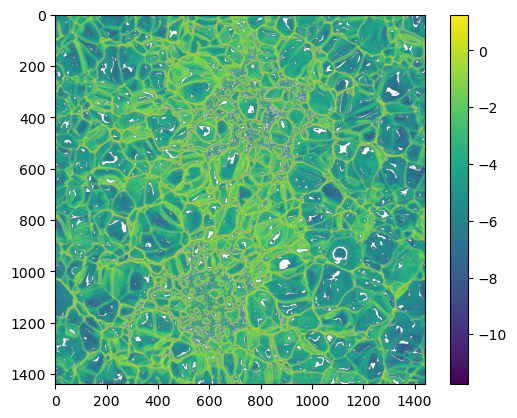

In [71]:
plt.imshow(np.log10(qjoule[:,:,z_index_0[0]]))
plt.colorbar()

In [60]:
dd.params['u_b'][0], qgenrad.shape, qtot.shape, dd.params['u_e'][0]/dd.params['u_t'][0]

(1121.0, (1440, 1440, 1186), (1440, 1440, 1186), 1000.0)

In [13]:
# gets the z coordinates of data points and makes an empty array of the same length for values of dz
zarr = dd.z
length = zarr.shape[0]
dzarr = np.empty([length])


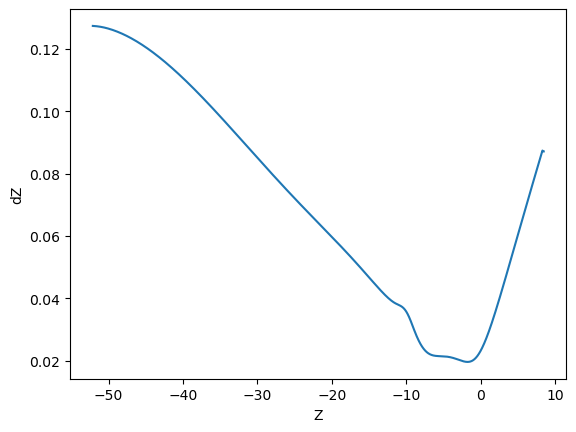

In [14]:
for i, val in enumerate(zarr):
    if i < length - 1 :
        dzarr[i] = zarr[i + 1] - val
        i = i + 1

    else :
        dzarr[i] = dzarr[i - 1]

# plots z vs dz and labels the axes
plt.plot(zarr, dzarr)
plt.xlabel('Z')
plt.ylabel('dZ')
plt.show()


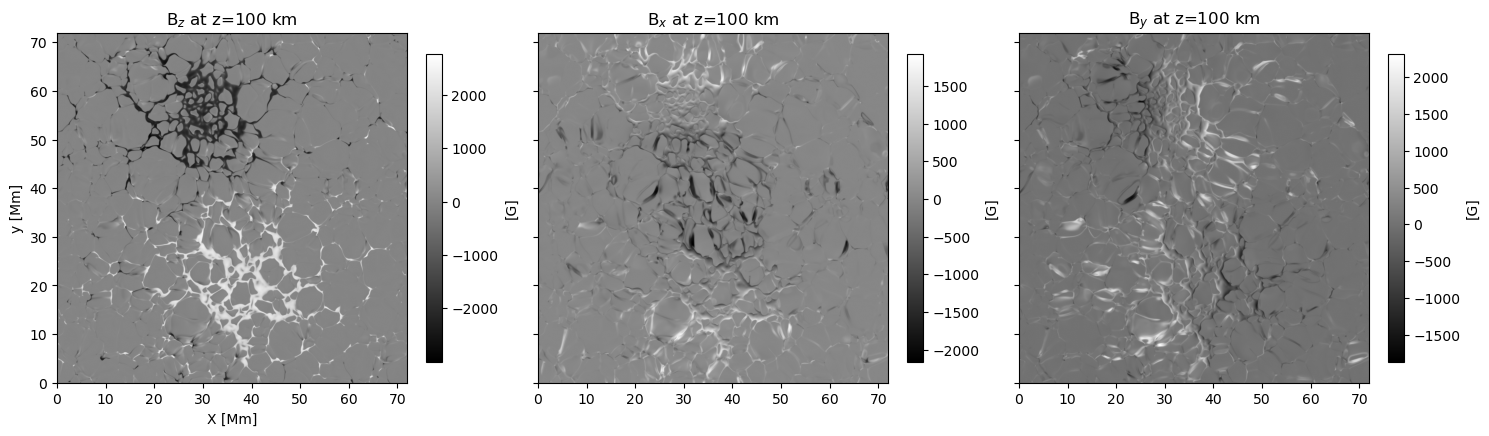

In [187]:
fig, ax = plt.subplots(ncols =3, nrows=1, sharex=True, sharey=True,figsize=(15,5))
ax=ax.ravel()
z_0 = closest_z_index(0.1,zarr)
im = ax[0].imshow(bz_bif[:,:,z_0]*dd.params['u_b'][0], origin='lower',cmap='gray',
extent=[0,0.05*bz_bif.shape[0],0,0.05*bz_bif.shape[1]])
plt.colorbar(im,fraction=0.04,label='[G]')
ax[0].set_title(r'B$_{z}$ at z=100 km')
ax[0].set_xlabel('X [Mm]')
ax[0].set_ylabel('y [Mm]')

im = ax[1].imshow(bx_bif[:,:,z_0]*dd.params['u_b'][0], origin='lower',cmap='gray',
extent=[0,0.05*bz_bif.shape[0],0,0.05*bz_bif.shape[1]])
plt.colorbar(im,fraction=0.04,label='[G]')
ax[1].set_title(r'B$_{x}$ at z=100 km')

im = ax[2].imshow(by_bif[:,:,z_0]*dd.params['u_b'][0], origin='lower',cmap='gray',
extent=[0,0.05*bz_bif.shape[0],0,0.05*bz_bif.shape[1]])
plt.colorbar(im,fraction=0.04,label='[G]')
ax[2].set_title(r'B$_{y}$ at z=100 km')

plt.tight_layout()
plt.savefig('/mn/stornext/d20/RoCS/souvikb/pl072050_results/Bx_By_Bz_z=100.png', dpi=300, bbox_inches='tight')

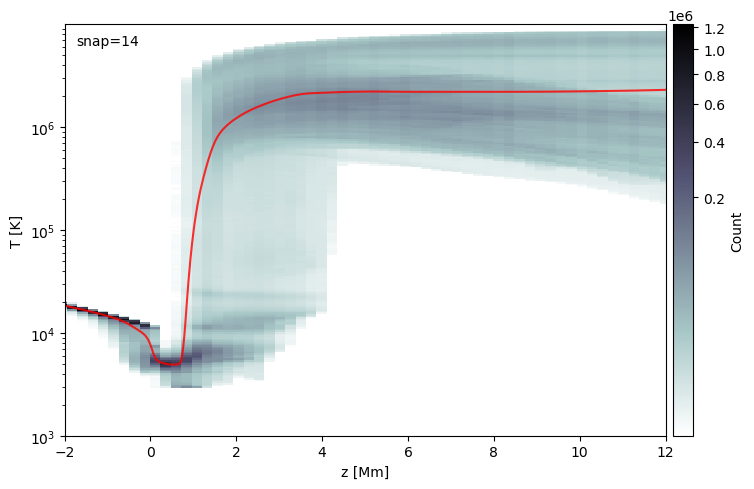

<Figure size 640x480 with 0 Axes>

In [235]:
# A: shape (Nx, Ny, Nz); z: shape (Nz,)
density_z_vs_value_logy(Tg[800:1400,500:900,:], z=zarr*(-1), nbins_z=250, nbins_val=250,
                        val_range=(1e3, 1e7), smooth_sigma=0,
                        cmap='bone_r', annotate='snap=14')
plt.show()
plt.savefig('/mn/stornext/d20/RoCS/souvikb/pl072050_results/T_density_plot.png', dpi=300, bbox_inches='tight')

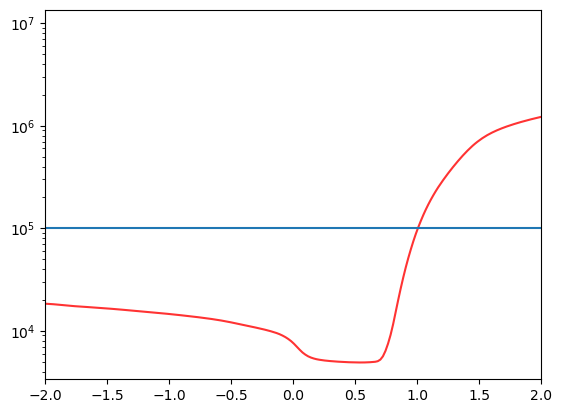

In [236]:
A=Tg[800:1400,500:900,:]
plt.plot(zarr*(-1),np.mean(np.mean(A,axis=0),axis=0),color='red',alpha=0.8)
plt.yscale('log')
plt.xlim([-2,2])
plt.axhline(y=1e5)

In [ ]:
z_value = zarr[np.argmin(np.mean(np.mean(A,axis=0),axis=0))]
closest_z_index(, zarr)      

array([978])

In [192]:
### Obtaining the heating proxy in the range z=0.535 to 1.0 Mm
## Normalize by the plasma density rho
summed_Q = qjoule + qvisc #+ qspitz
summed_Q = (1e-20+summed_Q)*1e3
den = (1e-20+rho)*1e-7
heat_per_part = summed_Q/den

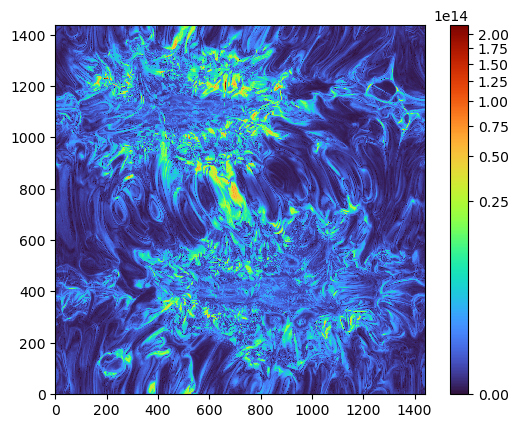

In [196]:
from matplotlib import colors
# mask = np.where(Tg >= 6000 and Tg<=80000, 1.,0)
plt.imshow((heat_per_part[:,:,900]), cmap='turbo',norm=colors.PowerNorm(0.3,vmin=0),interpolation='none',
origin='lower')
plt.colorbar()

In [188]:
# mask = np.where((Tg >= 6000) & (Tg<=80000), 1.,0)
zarr

array([-52.1112898 , -51.9838528 , -51.8564338 , ...,   8.32212114,
         8.40956713,   8.49673653])

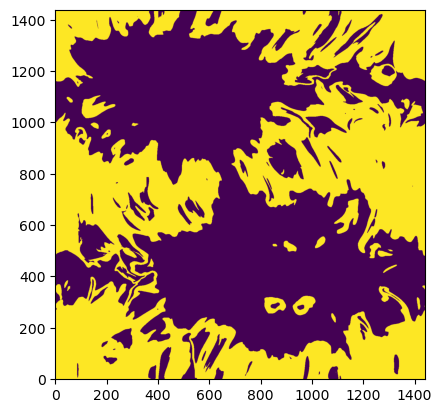

In [186]:
plt.imshow(mask[:,:,900], origin='lower')

In [234]:
## saving the required arrays
save=1
if save:
    # np.savez('/mn/stornext/d20/RoCS/souvikb/pl072050_results/pl072050_B.npz', Bx = bx_bif[:,:,z_0]*dd.params['u_b'][0], By=by_bif[:,:,z_0]*dd.params['u_b'][0],
    # Bz=bz_bif[:,:,z_0]*dd.params['u_b'][0], zax = zarr)
    # np.savez_compressed('/mn/stornext/d20/RoCS/souvikb/pl072050_results/pl072050_Q_per_rho.npz', heat_per_part = heat_per_part)
    np.savez('/mn/stornext/d20/RoCS/souvikb/pl072050_results/pl072050_integ_Q_per_rho.npz',integrated_q_per_part = integ_heat_rho)

In [229]:
## Trapezoidal integration
from scipy.integrate import trapezoid
integ_heat_rho = trapezoid(heat_per_part[:,:,955:979], x = zarr[955:979], axis=-1)
integ_heat_rho.shape

(1440, 1440)

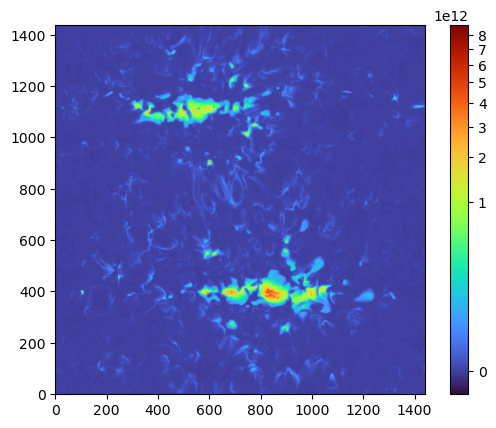

In [233]:
plt.imshow(integ_heat_rho,norm=colors.PowerNorm(0.3),origin='lower', cmap='turbo')
plt.colorbar()

In [228]:
zarr[955:979]

array([-1.00991333, -0.98975357, -0.9695619 , -0.94933721, -0.92907838,
       -0.90878426, -0.8884537 , -0.86808553, -0.84767857, -0.8272316 ,
       -0.80674343, -0.78621282, -0.76563852, -0.74501928, -0.72435382,
       -0.70364086, -0.68287909, -0.66206719, -0.64120382, -0.62028764,
       -0.59931729, -0.57829138, -0.55720852, -0.53606729])

In [ ]:
print(zarr[9])

-1.84046848


In [217]:
978-65

913